In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [4]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>

Создадим копии датасетов, с которыми будем работать, чтобы не менять исходники

In [5]:
train_df = train.copy()
test_df = test.copy()

Посмотрим какой объём оперативной памяти занимают датасеты:

In [6]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время. 

Исходя из этого необходимо уменьшить занимаемый ими объём памяти. Сделаем это при помощи способа с изменением типов переменных

Напишем функцию подсчёта объема занимаемой памяти:

In [7]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Преобразуем все значения подтипов ```float``` в тип ```float```

In [8]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [9]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



Видим, что объём занимаемой памяти тренировочного и тестового датасетов после изменения числовых типов данных уменьшился примерно на ```35 %```

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(399), object(31), uint16(1), uint32(2), uint8(1)
memory usage: 1.0+ GB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(399), object(31), uint16(1), uint32(2)
memory usage: 895.9+ MB


#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [12]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [13]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

Удаляем признаки, в которых более ```80 %``` пропусков:

In [14]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 80.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 74 columns.


In [15]:
missing_df

,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
...,...,...
V285,12,0.0
V284,12,0.0
V280,12,0.0
V279,12,0.0


In [16]:
train_df = train_df.drop(columns = missing_columns)

In [17]:
train_df.shape

(590540, 360)

In [18]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 359)

Посмотрим ещё раз на пропуски 

In [19]:
missing_values_table(train_df, 'train_df')

train_df has  360 columns.
 There are 340 columns that have missing values.


,Missing Values,% of Total Values
DeviceInfo,471874,79.9
id_13,463220,78.4
id_16,461200,78.1
V233,460110,77.9
V249,460110,77.9
...,...,...
V309,12,0.0
V310,12,0.0
V311,12,0.0
V312,12,0.0


In [20]:
missing_values_table(test_df, 'test_df')

test_df has  359 columns.
 There are 311 columns that have missing values.


,Missing Values,% of Total Values
DeviceInfo,391634,77.3
id_16,380944,75.2
V235,379963,75.0
V252,379963,75.0
V249,379963,75.0
...,...,...
V307,3,0.0
V308,3,0.0
V309,3,0.0
V310,3,0.0


In [21]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.950001,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Заполним пропуски тренировочного и тестового датасетов

Создадим списки числовых и категориальных признаков:

In [22]:
cat_features = train_df.select_dtypes(include=['object']).columns
num_features = [x for x in train_df.columns.values[2:] 
                if x not in cat_features]
print('len cat_features: ', len(cat_features))
print('len num_features: ', len(num_features))

len cat_features:  26
len num_features:  332


Пропуски в числовых признаках мы заполним средним по колонке

In [23]:
train_df[num_features] = train_df[num_features].fillna(
    train_df[num_features].mean())

Для категориальных признаков будем использовать ```-1.0``` в качестве символа пропуска:

In [24]:
train_df = train_df.fillna(-1)

In [25]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,362.555511,150.0,discover,142.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2987001,0,86401,29.000000,W,2755,404.000000,150.0,mastercard,102.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2987002,0,86469,59.000000,W,4663,490.000000,150.0,visa,166.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2987003,0,86499,50.000000,W,18132,567.000000,150.0,mastercard,117.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2987004,0,86506,50.000000,H,4497,514.000000,150.0,mastercard,102.0,...,144.000000,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,362.555511,150.0,visa,226.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590536,3577536,0,15811049,39.500000,W,10444,225.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590537,3577537,0,15811079,30.950001,W,12037,595.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590538,3577538,0,15811088,117.000000,W,7826,481.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1


Аналогично заполним пропуски в тестовом датасете:

In [26]:
test_df[num_features] = test_df[num_features].fillna(
    test_df[num_features].mean())

In [27]:
test_df = test_df.fillna(-1)

#### Посмотрим на распределение целевой переменной ```isFraud```

In [28]:
isFraud_count = train_df['isFraud'].value_counts()
isFraud_prct = train_df['isFraud'].value_counts()/len(train_df)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,569877,0.96501
1,20663,0.03499


In [29]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[df[feature] != -1][feature].value_counts().plot(kind='bar',
                                        figsize=(7,5),
                                        xlabel=title,
                                        ylabel='count',
                                        edgecolor='k',
                                        color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

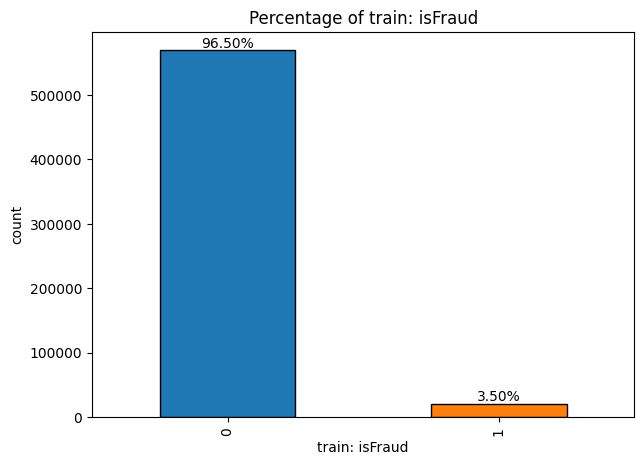

In [30]:
plot_value_counts('isFraud', 'train: isFraud', df=train_df)

Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

#### Распределение ```Card 4``` (компания карты)

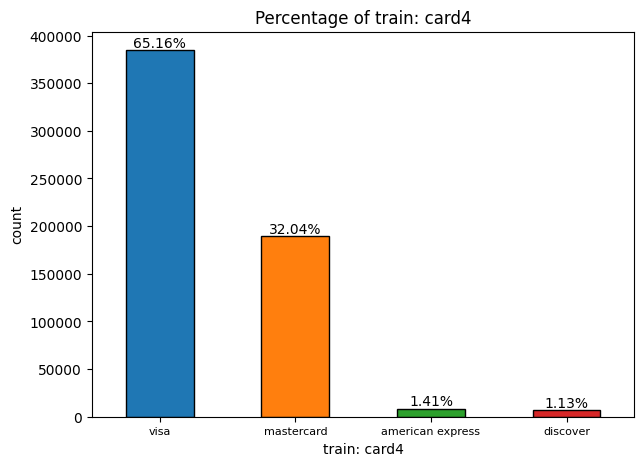

In [31]:
plot_value_counts('card4', 'train: card4', df=train_df)

Видим, что:

- ```65,16 %``` - карт компании 'visa'
- ```32,04 %``` - 'mastercard'
- ```1,41 %```  - 'american express'
- ```1,13 %```  - 'discover'

#### Распределение ```Card 6``` - тип карты

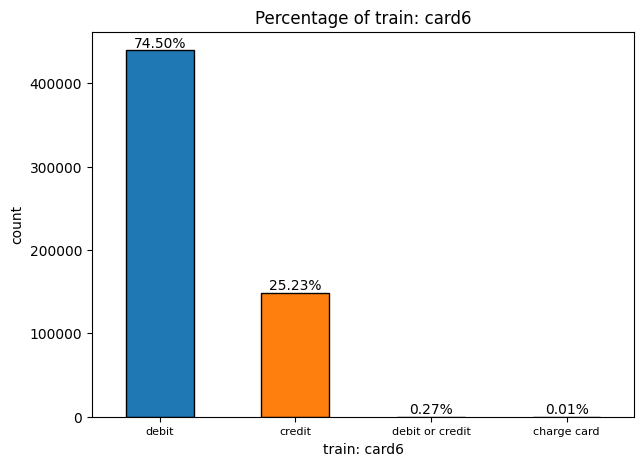

In [32]:
plot_value_counts('card6', 'train: card6', df=train_df)

Большая часть транзакций произведена дебетовыми картами - ```74,5 %```, ```25,23 %``` - кредитными картами. Транзакций с ```charge``` карт нет

#### Распределение транзакций по ```DeviceType```

DeviceType
desktop    85165
mobile     55645
Name: TransactionDT, dtype: int64


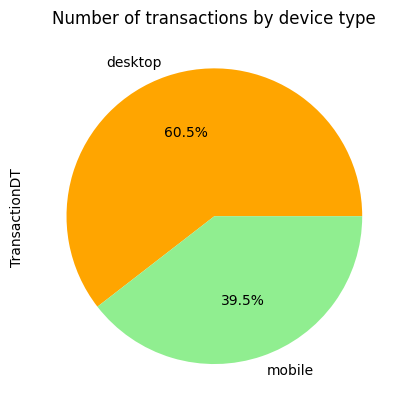

In [33]:
device_type_df = train_df[train_df['DeviceType']!=-1].groupby(by='DeviceType').TransactionDT.count()
device_type_df.plot(kind='pie', 
                    colors=['orange', 'lightgreen'],
                    autopct='%1.1f%%')
plt.title('Number of transactions by device type')
print(device_type_df)

Большинство транзакций было выполнено с компьютера - ```60.5 %```

С мобильных устройств - ```39.5 %``` транзакций

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [34]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df[df[feature]!=-1])
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

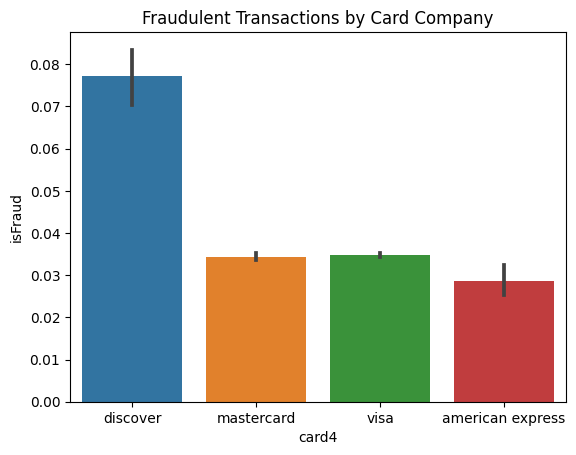

In [35]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

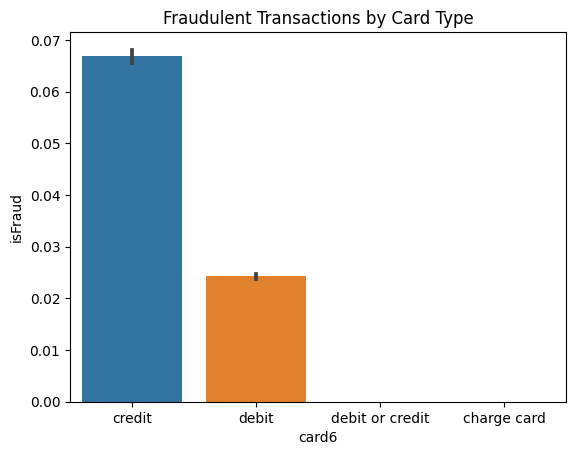

In [36]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

#### Распределение транзакций в разрезе типа устройства

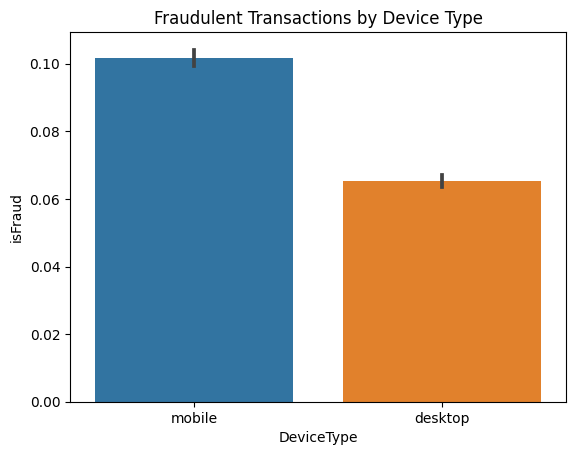

In [37]:
isFraud_by_feature('DeviceType', df=train_df, title='Device Type')

Большинство транзакций было произведено с мобильных устройств

#### Построим гистограмму распределения транзакционных платежей (TransactionAMT)

Напишем функцию для построения гистограммы:

In [38]:
def plt_hist(df, feature, bins=150):
    plt.figure(figsize=(8,8))
    plt.hist(df[feature], bins=bins, edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title('Distribution of {}'.format(feature))
    plt.show()

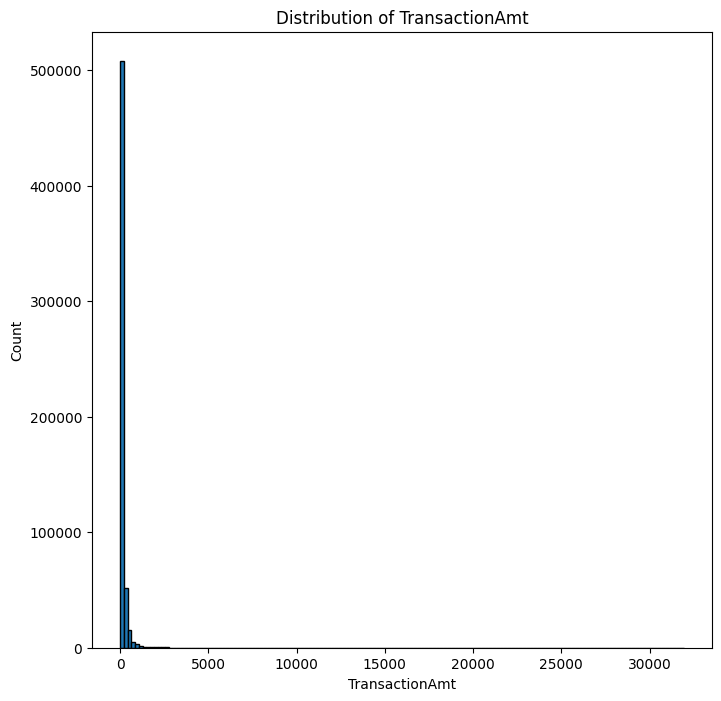

In [39]:
plt_hist(train_df, 'TransactionAmt')

#### Здесь виден явный выброс в данных

Посмотрим на статистики этого признака

In [40]:
train_df['TransactionAmt'].describe()

count    590540.000000
mean        135.027161
std         239.162521
min           0.251000
25%          43.320999
50%          68.769001
75%         125.000000
max       31937.390625
Name: TransactionAmt, dtype: float64

Посмотрим на топ 10 самых больших значений этого столбца

In [41]:
train_df['TransactionAmt'].dropna().sort_values().tail(10)

315172     5279.950195
462514     5279.950195
584767     5366.819824
275535     5420.000000
275529     5420.000000
384603     5543.229980
248413     6085.229980
296021     6450.970215
274336    31937.390625
274339    31937.390625
Name: TransactionAmt, dtype: float32

Выведем график ```boxplot```, чтобы убедиться, что эти значения похожи на выбросы

Напишем функцию для построения диаграммы размаха:

In [42]:
def plt_boxplot(df, feature):
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха платежей')
    plt.xlabel(feature)
    plt.show()

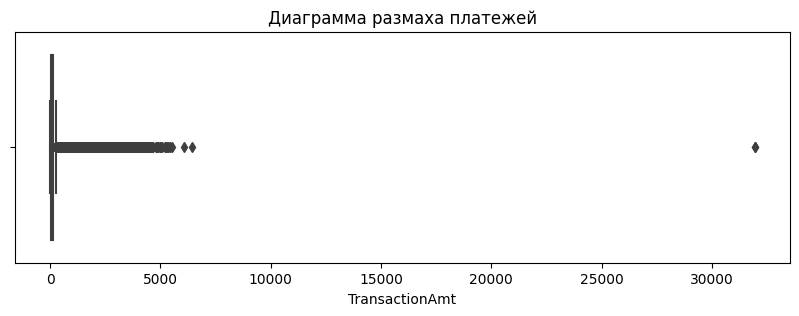

In [43]:
plt_boxplot(train_df, 'TransactionAmt')

#### Избавимся от выбросов

Напишем функцию для того, чтобы отделить данные от выбросов

In [44]:
def data_without_feat_emsns(df, feature):
    first_qrt = df[feature].describe()['25%']
    third_qrt = df[feature].describe()['75%']
    iqr = third_qrt - first_qrt
    
    condition = (df[feature] > (first_qrt - 3 * iqr)) & \
    (df[feature] < (third_qrt + 3 * iqr))
    
    df = df[condition]
    return df

Применим созданную функцию к нашим данным, отфильтровав строки, не являющиеся выбросами

In [45]:
train_df = data_without_feat_emsns(train_df, 'TransactionAmt')

In [46]:
train_df.shape

(554118, 360)

In [47]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,362.555511,150.0,discover,142.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2987001,0,86401,29.000000,W,2755,404.000000,150.0,mastercard,102.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2987002,0,86469,59.000000,W,4663,490.000000,150.0,visa,166.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2987003,0,86499,50.000000,W,18132,567.000000,150.0,mastercard,117.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2987004,0,86506,50.000000,H,4497,514.000000,150.0,mastercard,102.0,...,144.000000,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,362.555511,150.0,visa,226.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590536,3577536,0,15811049,39.500000,W,10444,225.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590537,3577537,0,15811079,30.950001,W,12037,595.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590538,3577538,0,15811088,117.000000,W,7826,481.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1


Построим ещё раз гистограмму распределения поля ```TransactionAmt```

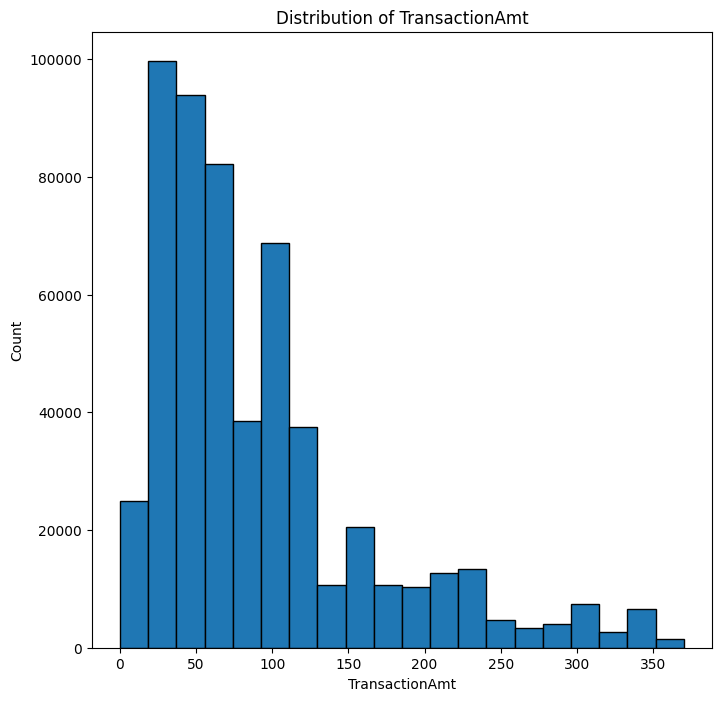

In [48]:
plt_hist(train_df, 'TransactionAmt', bins=20)

Также ещё раз построим ```boxplot```, чтобы убедиться в отсутствии выбросов

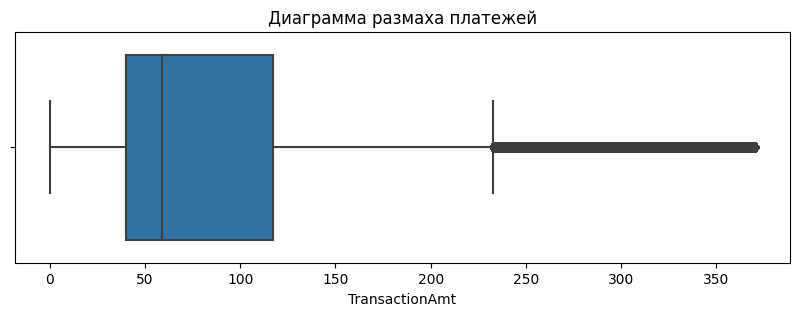

In [49]:
plt_boxplot(train_df, 'TransactionAmt')

Посмотрим на распределение ```TransactionAmt``` на **тестовом датасете**:

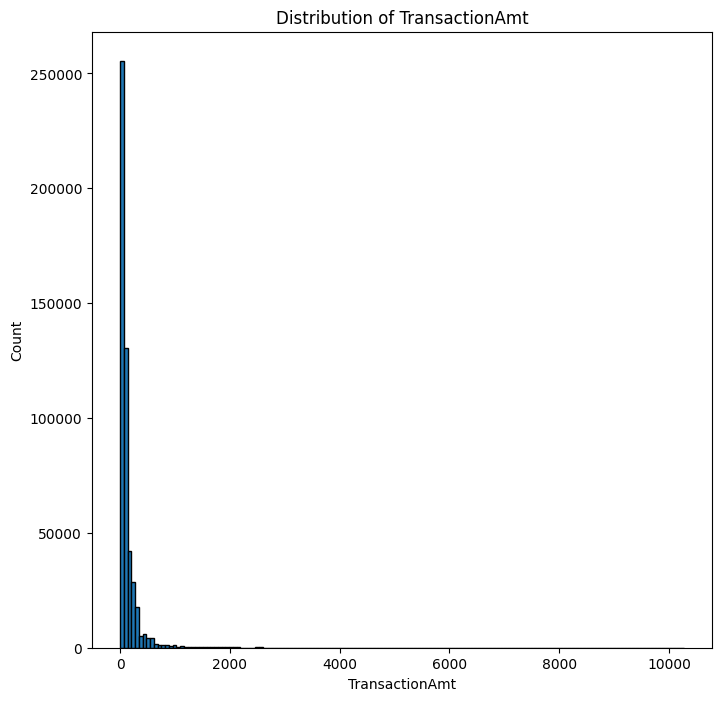

In [50]:
plt_hist(test_df, 'TransactionAmt')

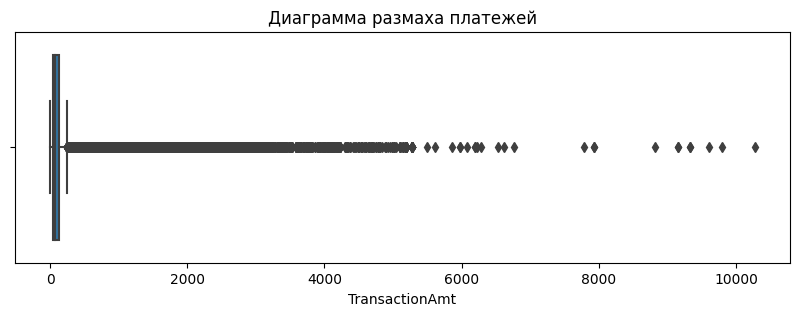

In [51]:
plt_boxplot(test_df, 'TransactionAmt')

Аналогично очистим тестовый датасет от выбросов признака ```TransactionAMT```

In [52]:
test_df = data_without_feat_emsns(test_df, 'TransactionAmt')
test_df.shape

(476384, 359)

Построим гистограмму распределения и диаграмму размаха платежей для тестового датасета после очистки данных от выбросов

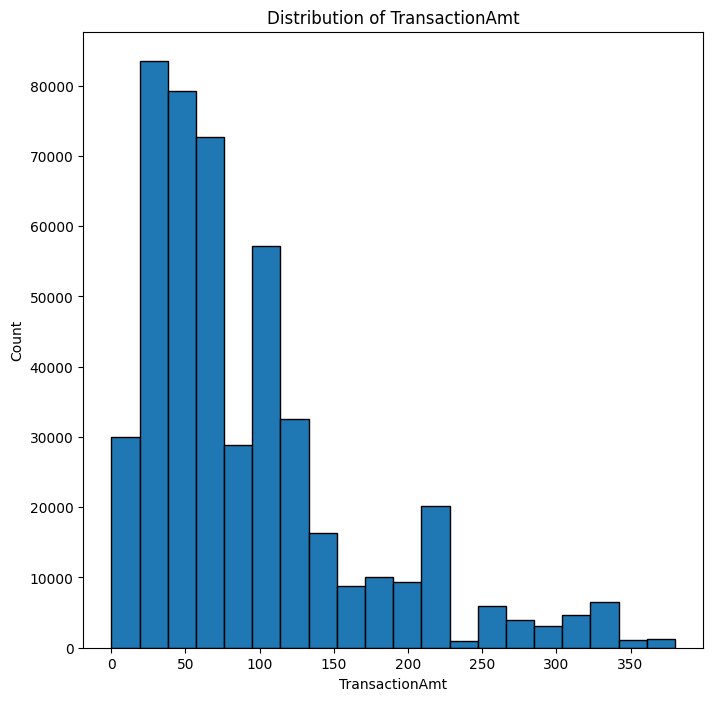

In [53]:
plt_hist(test_df, 'TransactionAmt', bins=20)

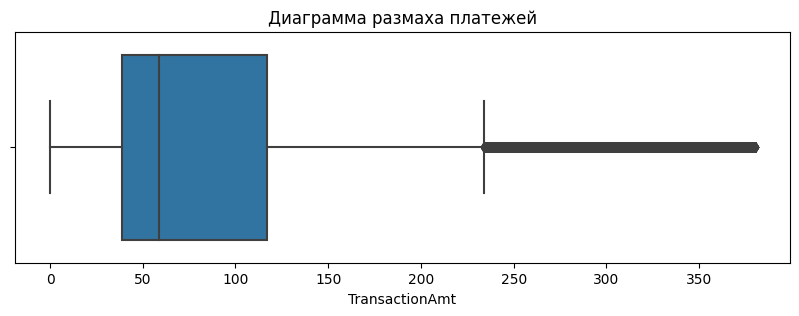

In [54]:
plt_boxplot(test_df, 'TransactionAmt')

Используя ```Label Encoder``` преорабразуем категориальные признаки в числа в тренировочном и тестовом датасетах

In [55]:
for f in train_df.columns:
    if train_df.loc[:, f].dtype=='object':
        le = LabelEncoder()
        le.fit(list(train_df.loc[:, f].values))
        train_df.loc[:, f] = le.transform(list(train_df.loc[:, f].values))

In [56]:
for f in test_df.columns:
    if test_df.loc[:, f].dtype=='object':
        le = LabelEncoder()
        le.fit(list(test_df.loc[:, f].values))
        test_df.loc[:, f] = le.transform(list(test_df.loc[:, f].values))

Посмотрим на категориальные признаки в датасетах после преобразований

In [57]:
train_df[cat_features]

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,4,2,2,0,0,2,2,2,3,1,...,0,0,0,0,0,0,0,0,0,0
1,4,3,2,17,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,4,4,3,36,0,2,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,3,3,54,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
4,1,3,2,17,0,0,0,0,0,0,...,2,2,2,124,2,1,2,2,2,954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,4,4,3,0,0,2,2,2,1,2,...,0,0,0,0,0,0,0,0,0,0
590536,4,3,3,17,0,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
590537,4,3,3,17,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
590538,4,3,3,3,0,2,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [58]:
test_df[cat_features]

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,4,4,3,17,0,2,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,3,3,0,2,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4,4,3,20,0,2,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,4,3,17,0,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3,3,17,0,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,0,3,3,17,17,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
506687,0,3,3,20,20,0,0,0,3,0,...,2,2,2,6,1,1,2,1,2,107
506688,4,4,3,20,0,2,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0
506689,4,3,3,20,0,2,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


Ещё раз посмотрим на информацию по данным

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554118 entries, 0 to 590539
Columns: 360 entries, TransactionID to DeviceInfo
dtypes: float32(330), object(26), uint16(1), uint32(2), uint8(1)
memory usage: 817.5+ MB


В данных имеются значения типа ```object```. Данный тип не подходит для обучения модели. Преобразуем его в тип ```int```, т.к. мы уже выполнили преобразование категориальных признаков в числовые

In [60]:
object_train_data = train_df.select_dtypes(include=['object'])
convert_object_train_data = object_train_data.apply(
    pd.to_numeric, downcast='unsigned')

train_df[convert_object_train_data.columns] = convert_object_train_data


/tmp/ipykernel_20/4197225427.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[convert_object_train_data.columns] = convert_object_train_data


In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554118 entries, 0 to 590539
Columns: 360 entries, TransactionID to DeviceInfo
dtypes: float32(330), uint16(2), uint32(2), uint8(26)
memory usage: 721.9 MB


In [62]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,4,13926,362.555511,150.0,2,142.0,...,403.882568,0,0,0,0,0,0,0,0,0
1,2987001,0,86401,29.000000,4,2755,404.000000,150.0,3,102.0,...,403.882568,0,0,0,0,0,0,0,0,0
2,2987002,0,86469,59.000000,4,4663,490.000000,150.0,4,166.0,...,403.882568,0,0,0,0,0,0,0,0,0
3,2987003,0,86499,50.000000,4,18132,567.000000,150.0,3,117.0,...,403.882568,0,0,0,0,0,0,0,0,0
4,2987004,0,86506,50.000000,1,4497,514.000000,150.0,3,102.0,...,144.000000,2,2,124,2,1,2,2,2,954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,4,6550,362.555511,150.0,4,226.0,...,403.882568,0,0,0,0,0,0,0,0,0
590536,3577536,0,15811049,39.500000,4,10444,225.000000,150.0,3,224.0,...,403.882568,0,0,0,0,0,0,0,0,0
590537,3577537,0,15811079,30.950001,4,12037,595.000000,150.0,3,224.0,...,403.882568,0,0,0,0,0,0,0,0,0
590538,3577538,0,15811088,117.000000,4,7826,481.000000,150.0,3,224.0,...,403.882568,0,0,0,0,0,0,0,0,0


In [63]:
object_test_data = test_df.select_dtypes(include=['object'])
convert_object_test_data = object_test_data.apply(
    pd.to_numeric, downcast='unsigned')
test_df[convert_object_test_data.columns] = convert_object_test_data

In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476384 entries, 0 to 506690
Columns: 359 entries, TransactionID to DeviceInfo
dtypes: float32(330), uint16(2), uint32(2), uint8(25)
memory usage: 620.1 MB


Посмотрим на объёмы занимаемой памяти после преобразования числовых типов и кодирования типов ```object``` в числовые типы

Напишем функцию для подсчёт изменений памяти:

In [65]:
def memory_changes(start_mem_usage, df, df_name):
    cur_mem_usage = memory_usage(df)
    diff_mem = (start_mem_usage - cur_mem_usage)
    diff_mem_prct = 100-((cur_mem_usage * 100)/start_mem_usage)
    print(f'Memory usage of {df_name} decreased from {start_mem_usage} to {cur_mem_usage} on {diff_mem} Mb ({diff_mem_prct})%')

### ```train_df``` после преобразований

In [66]:
memory_changes(train_df_GB * 1024, df=train_df, df_name='train_df')

Memory usage of train_df decreased from 2567.094612121582 to 721.8601112365723 on 1845.2345008850098 Mb (71.88026854062893)%


### ```test_df``` после преобразований

In [67]:
memory_changes(test_df_GB * 1024, df=test_df, df_name='test_df')

Memory usage of test_df decreased from 2214.031036376953 to 620.1402282714844 on 1593.8908081054688 Mb (71.99044556817579)%


Отделим данные от целевой переменной

In [68]:
y = train_df['isFraud']
X = train_df.drop(['isFraud'], axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

Так как данные всё равно занимают достаточно большой объём памяти, разобъём датасет на несколько частей. Для каждой части создадим и обучим модель, а затем усредним предсказания моделей при помощи ансамбля

In [70]:
chunk_size = 4000
X_train_chunks = [X_train.iloc[i:i+chunk_size] \
                  for i in range(0, X_train.shape[0], chunk_size)]

In [71]:
y_train_chunks = [y_train.iloc[i:i+chunk_size] \
                 for i in range(0, y_train.shape[0], chunk_size)]

In [72]:
X_test_chunks = [X_test.iloc[i:i+chunk_size] \
                for i in range(0, X_test.shape[0], chunk_size)]
y_test_chunks = [y_test.iloc[i:i+chunk_size] \
                for i in range(0, y_test.shape[0], chunk_size)]

In [73]:
print('len X_train_chunks: ', len(X_train_chunks))
print('len y_train_chunks: ', len(y_train_chunks))
print('len X_test_chunks : ', len(X_test_chunks))
print('len y_test_chunks : ', len(y_test_chunks))

len X_train_chunks:  97
len y_train_chunks:  97
len X_test_chunks :  42
len y_test_chunks :  42


In [74]:
print('X_train chunk shape: ', X_train_chunks[0].shape)
print('y_train chunk shape: ', y_train_chunks[0].shape)
print('X_test chunk shape : ', X_test_chunks[0].shape)
print('y_test chunk shape : ', y_test_chunks[0].shape)

X_train chunk shape:  (4000, 359)
y_train chunk shape:  (4000,)
X_test chunk shape :  (4000, 359)
y_test chunk shape :  (4000,)


In [75]:
classifiers = [('DT', DecisionTreeClassifier()),
               ('RF', RandomForestClassifier()),
               ('Adaboost', AdaBoostClassifier()),
               ('GBM', GradientBoostingClassifier()),
               ('XGBBoost', XGBClassifier()),
               ('LightGBM', LGBMClassifier()),]

Создадим функцию для получения усредненного значения ```roc_auc_score``` после обучения и прогноза на каждом чанке 

In [76]:
def mean_AUC(X_tr_chunks, 
             y_tr_chunks, 
             X_t_chunks, 
             y_t_chunks, 
             classifier):
    # fit
    models = []
    for i in range(len(X_tr_chunks)):
        model = classifier.fit(X_tr_chunks[i], y_tr_chunks[i])
        models.append(model)
    
    roc_aucs = []
    for model in models:
        for i in range(len(X_t_chunks)):
#             y_pred = model.predict(X_t_chunks[i])
            y_prob = model.predict_proba(X_t_chunks[i])[:, 1]
            roc_auc = roc_auc_score(y_t_chunks[i], y_prob)
            roc_aucs.append(roc_auc)
    return np.mean(roc_aucs)

In [77]:
mean_AUC_DT = mean_AUC(X_train_chunks, 
                       y_train_chunks,
                       X_test_chunks,
                       y_test_chunks,
                       DecisionTreeClassifier())
mean_AUC_DT

0.6642872102110355

In [78]:
for name, classifier in classifiers:
    print(f' learn model {name}...')
    model = classifier.fit(X_train, y_train)
#     y_pred = model.predict(X_train)
#     y_prob = model.predict_proba(X_train)[:, 1]
#     print(classification_report(y_train, y_pred))
#     print(f' AUC: {roc_auc_score(y_train, y_prob)}')
    print('-------------------------------------')
    print(f' predictions')
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print(f' AUC: {roc_auc_score(y_test, y_prob)}')

 learn model DT...
-------------------------------------
 predictions
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    160603
           1       0.53      0.59      0.56      5633

    accuracy                           0.97    166236
   macro avg       0.76      0.78      0.77    166236
weighted avg       0.97      0.97      0.97    166236

 AUC: 0.7838789268960713
 learn model RF...
-------------------------------------
 predictions
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    160603
           1       0.94      0.46      0.62      5633

    accuracy                           0.98    166236
   macro avg       0.96      0.73      0.80    166236
weighted avg       0.98      0.98      0.98    166236

 AUC: 0.9285650580241152
 learn model Adaboost...
-------------------------------------
 predictions
              precision    recall  f1-score   support

           0       0.97  